In [1]:
%load_ext autoreload

In [566]:
%autoreload
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from gpt.model import SinusoidalEmbedding, RevIN, SelfAttention, CrossAttention, MLP
# from gpt.utils import flatten, nparams
from gpt.ts import TSTransformer
# from einops import rearrange
# import torch.optim as optim
# from tqdm.auto import tqdm
# import matplotlib

In [608]:
xs = torch.tensor(np.linspace(0, 50, 250), dtype=torch.float32)

num_series = 5_100
std = 0.2

periods = (0.1 + torch.rand(size=(num_series, 1)) * 0.5) * 2 * np.pi
phases = torch.rand(size=(num_series, 1)) * 2 * np.pi
offsets = torch.randn(size=(num_series, 1)) * 5
noise = torch.randn(size=(num_series, len(xs))) * std
_ys = torch.sin((xs.unsqueeze(0) + phases) / periods) + offsets + noise
ys = _ys.reshape(num_series, -1, 1).to(torch.float32)

[[<matplotlib.lines.Line2D at 0x1504994dd650>],

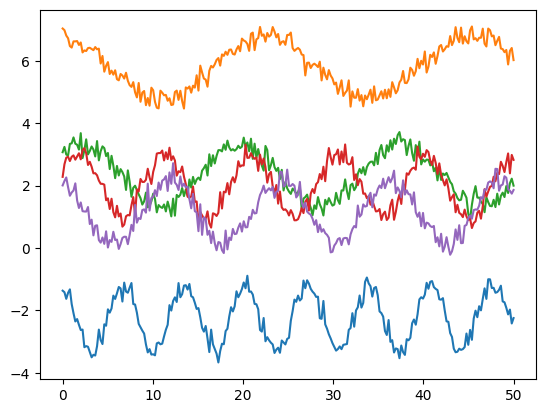

In [609]:
[plt.plot(xs, (ys[i,:,0])) for i in range(5)]

In [611]:
tst = TSTransformer(
    input_dim=1,
    embed_dim=64,
    num_layers=4,
    num_heads=4,
    mlp_ratio=4,
    dropout=0.1,
    min_period=0.1,
    max_period=10,
).cuda()

In [612]:
optimizer = optim.AdamW(tst.parameters(), lr=1e-3)

In [627]:
xsc, ysc = xs.cuda(), ys.cuda()
# losses = []

for e in (pbar := tqdm(range(1000))):
    for rix in torch.randperm(5000).chunk(100):
        optimizer.zero_grad()
        out = tst(xsc[:-1], ysc[rix,:-1,:])
        loss = F.mse_loss(out, ysc[rix,1:,:])
        losses.append(loss.item())
        pbar.set_description(f"epoch {e} | loss: {loss.item():.4f}")
        loss.backward()
        optimizer.step()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 2.19 MiB is free. Process 3112572 has 480.00 MiB memory in use. Process 4064916 has 1.18 GiB memory in use. Process 2256880 has 3.68 GiB memory in use. Including non-PyTorch memory, this process has 21.02 GiB memory in use. Process 3834405 has 454.00 MiB memory in use. Process 4034151 has 310.00 MiB memory in use. Process 4193450 has 2.65 GiB memory in use. Process 159636 has 310.00 MiB memory in use. Process 572531 has 1.11 GiB memory in use. Process 733115 has 482.00 MiB memory in use. Of the allocated memory 20.23 GiB is allocated by PyTorch, and 425.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [629]:
tst.load_state_dict(torch.load('../train/tst.pth'))

<All keys matched successfully>

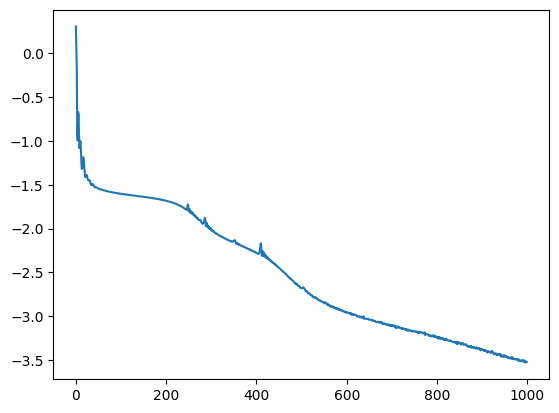

In [560]:
plt.plot(np.log(losses))

## next step prediction

In [633]:
with torch.inference_mode():
    out = tst(xsc[:-1], ysc[-10:,:-1,:]).detach().cpu()

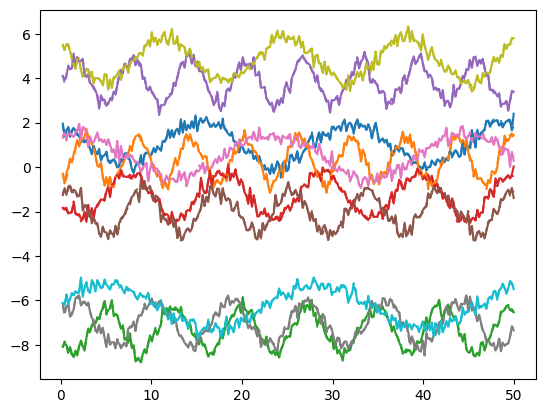

In [635]:
colors = matplotlib.colormaps.get_cmap('tab20')

[plt.plot(xs[1:], ys[-10+i,1:,0], c=colors(i / 10)) for i in range(10)]
[plt.plot(xs[1:], out[i,:,0], ls='--', c=colors(i / 10)) for i in range(10)];
# plt.xlim(20, 25)

In [636]:
with torch.inference_mode():
    out1 = tst.forecast(xsc, ysc[-10:,:100,:], recapture=False).cpu()
    # out2 = tst.forecast(xsc, ysc[-10:,:100,:], recapture=True).cpu()

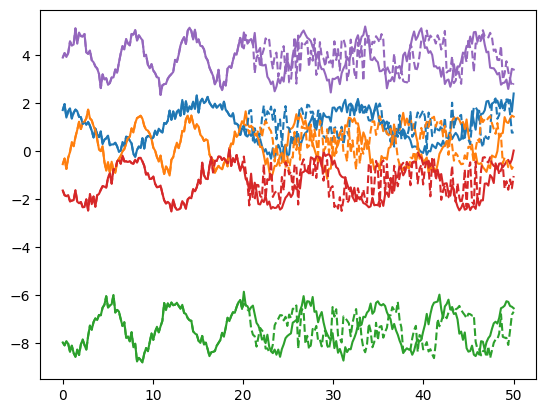

In [639]:
[plt.plot(xs, ys[-10+i,:,0], c=colors(i / 10)) for i in range(5)]
[plt.plot(xs, out1[i,:,0], ls='--', c=colors(i / 10)) for i in range(5)];
# [plt.plot(xs, out2[i,:,0], ls='--', c=colors(i / 10)) for i in range(10)];
# plt.xlim(20, 40)